# Lab 5

By Daniel Diamont (dd28977) Jerry Yang (jhy395) Zhaofeng Liang (zl4685)

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Q1

In [25]:
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")


In [27]:
if (train.isnull() is True):
    print ("missing value")
else:
    print ("no missing value")
    
train.head()

no missing value


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110ce13d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1116f4210>]], dtype=object)

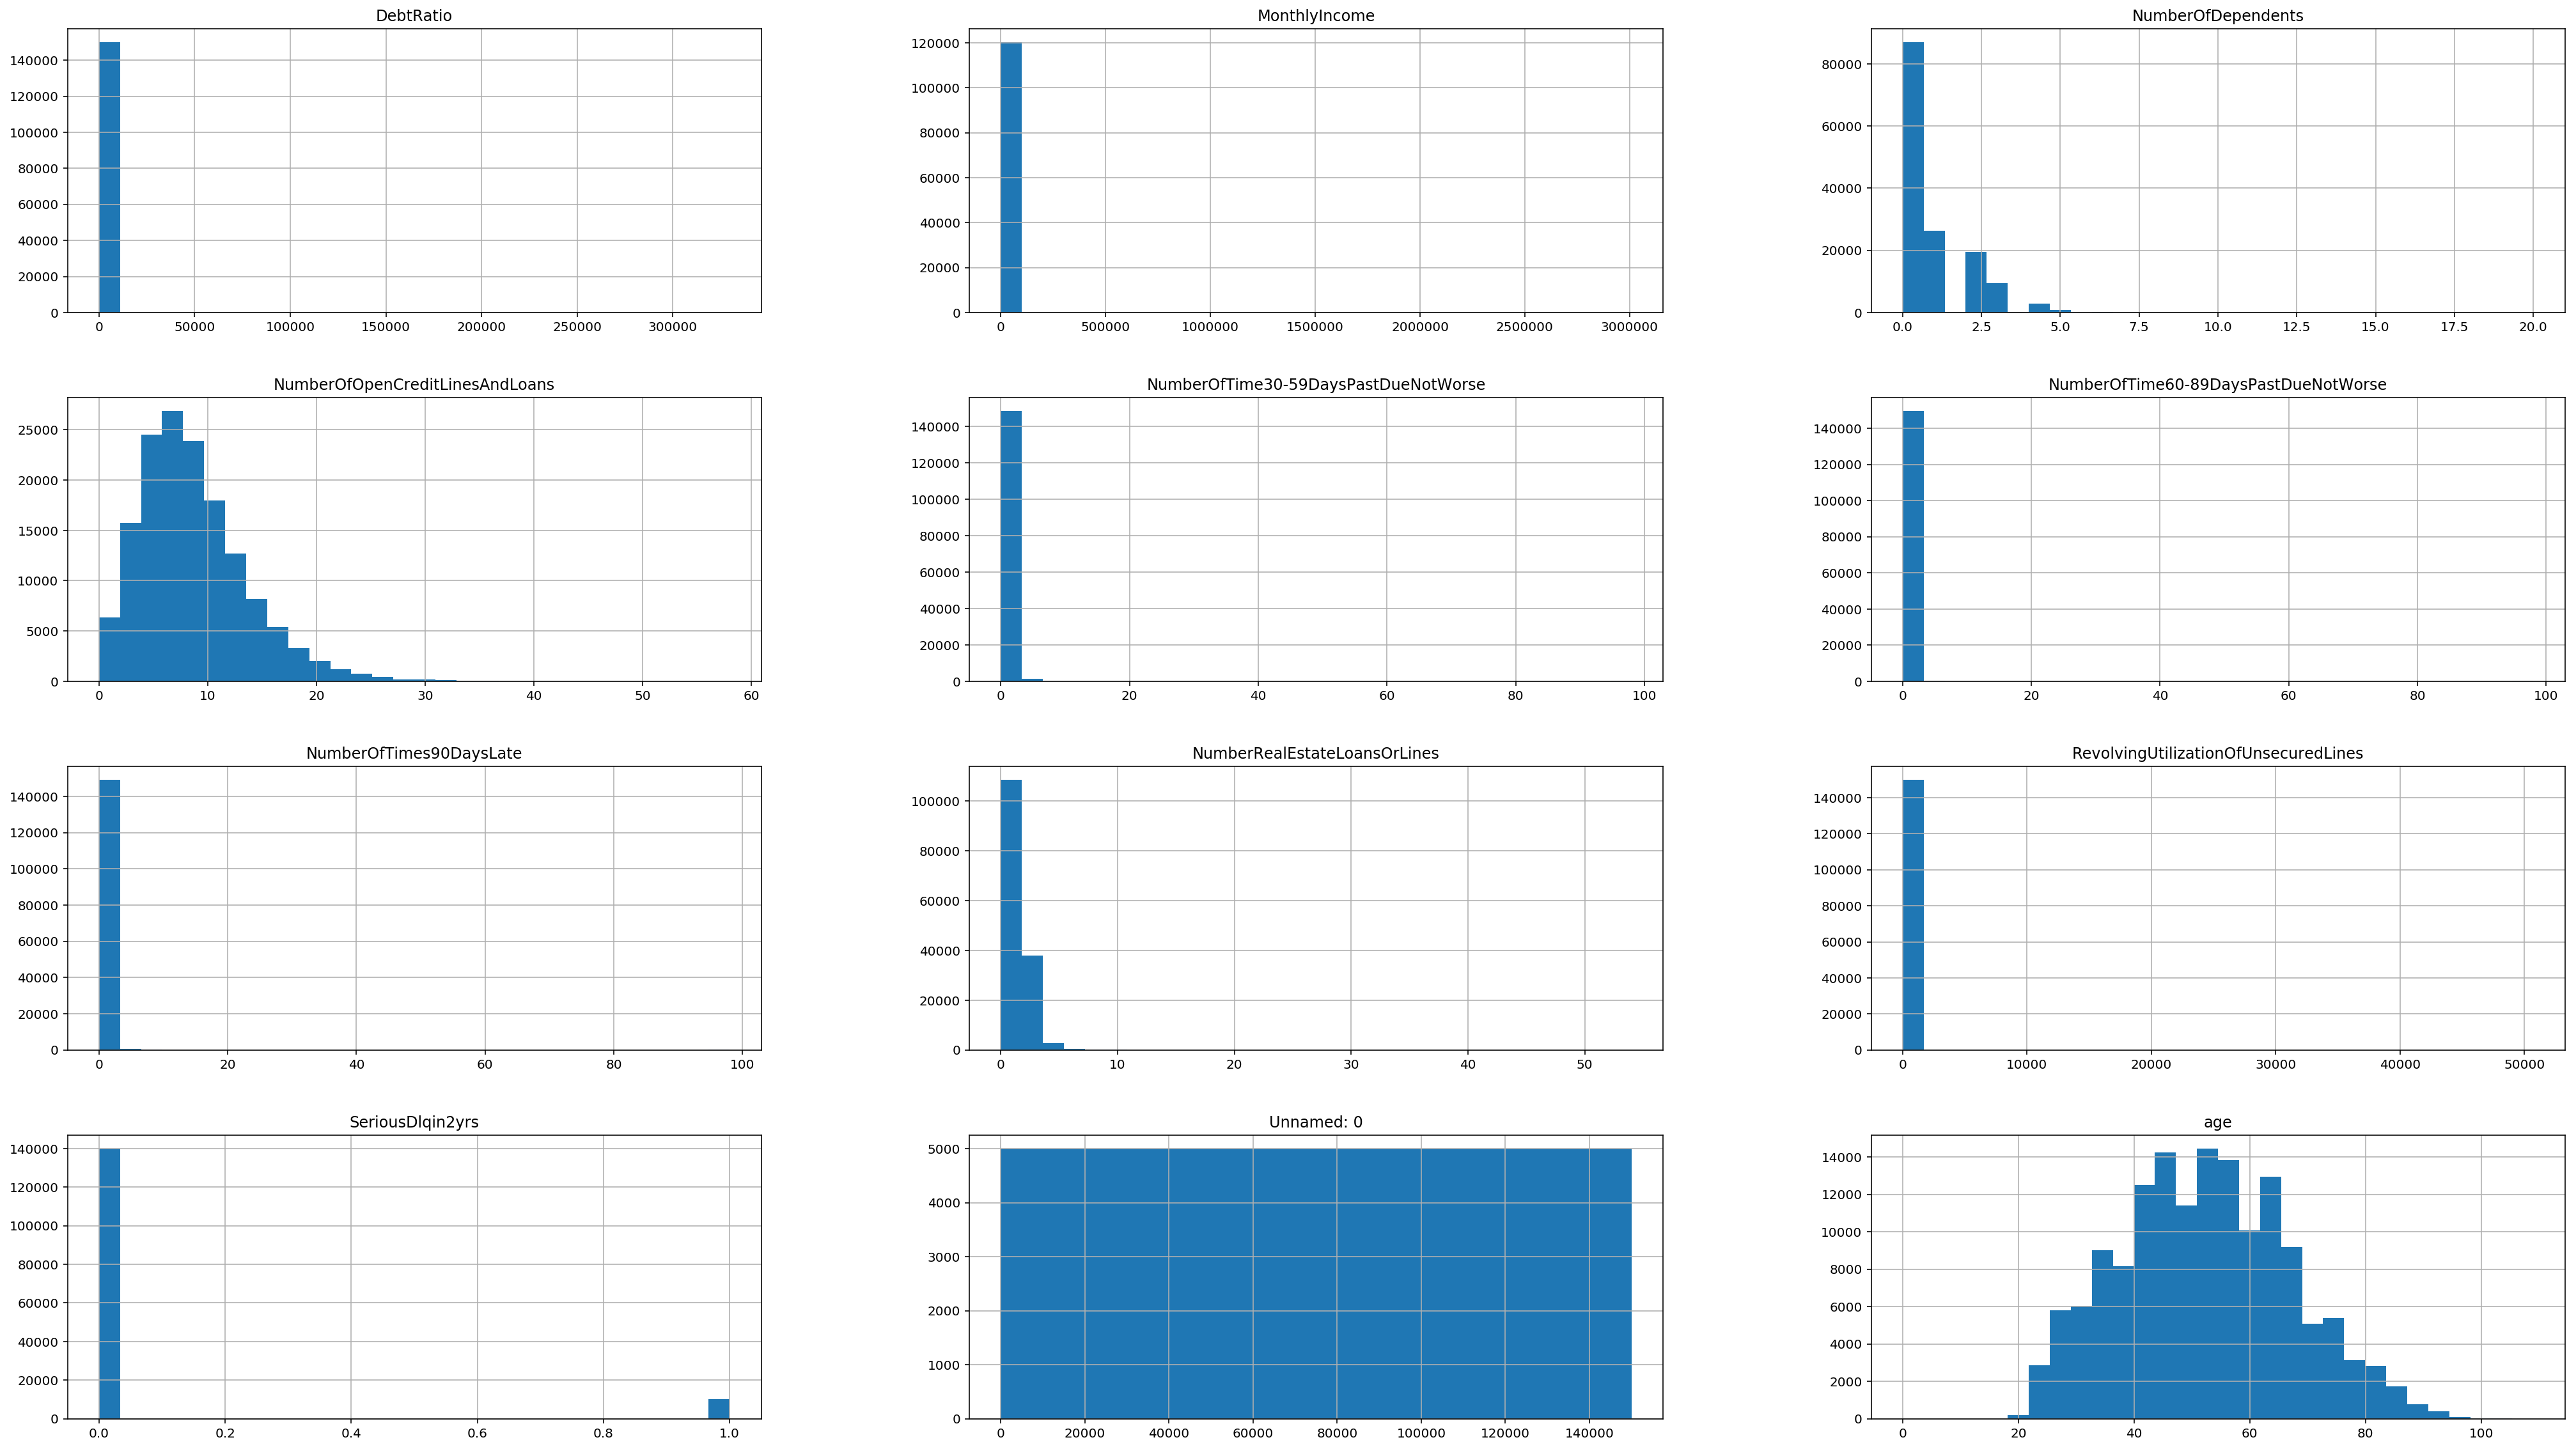

In [9]:
#Display all histograms to see data distributions for each features
matplotlib.rcParams['figure.figsize'] = (35.0, 20.0)
train.hist(bins = 30, figsize = (35.0, 20.0))

### 1.0

In [54]:
train_df = pd.read_csv('cs-training.csv')
Y = train_df['SeriousDlqin2yrs'].values
X = train_df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
test_df = pd.read_csv('cs-test.csv')
test = test_df.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }


xgb = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 4
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

random_search.fit(X, Y)

y_test = random_search.predict_proba(test)
results_df = pd.DataFrame(data={'Id':test_df['Unnamed: 0'], 'Probability':y_test[:,1]})
results_df.to_csv('xgbclassifier.csv', index=False)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV] subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5 
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.855025526172, total= 1.7min
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.855865871952, total= 1.7min
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, gamma=0.3, min_child_weight=1 
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, gamma=0.3, min_child_weight=1 
[CV]  subsample=0.9, colsample_bytree=1.0, max_depth=4, gamma=0.5, min_child_weight=5, score=0.862335806575, total= 1.7min
[CV] subsample=0.5, colsample_bytree=0.8, max_depth=6, 

[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 12.9min finished


Since we are classifying if someone is a high-risk individual, the XGBClassifier will be a good model that fits this problem. We ran a standard XGBClassifier with StratifiedKFold and submit the result to Kaggle, resulting a private score of 0.863163.

### 1.1

In [28]:
#Simple Model such as XGBClassifier
xgb = xgb.fit(X,Y)

#No extra on MonthlyIncome
preds_0 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with no extra MonthlyIncome is: %0.5f" %preds_0.mean())

#$1000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_1000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $1000 extra MonthlyIncome is: %0.5f" %preds_1000.mean())

#$2000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_2000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $2000 extra MonthlyIncome is: %0.5f" %preds_2000.mean())

#$3000 extra on MonthlyIncome
test.MonthlyIncome = test.MonthlyIncome + 1000
preds_3000 = xgb.predict_proba(test)[:,1]
print("Probability of delinquency with $3000 extra MonthlyIncome is: %0.5f" %preds_3000.mean())


Probability of delinquency with no extra MonthlyIncome is: 0.06236
Probability of delinquency with $1000 extra MonthlyIncome is: 0.06162
Probability of delinquency with $2000 extra MonthlyIncome is: 0.06102
Probability of delinquency with $3000 extra MonthlyIncome is: 0.06070


From the above result, we can see as the MonthlyIncome increases, the probability of delinquency decreases. Which make sense, higher income is a indication of financial stability, therefore lower the chance of delinquency.

### 1.2

In [5]:
train_df = pd.read_csv('cs-training.csv')
Y = train_df['SeriousDlqin2yrs'].values
X = train_df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
test_df = pd.read_csv('cs-test.csv')
test = test_df.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }


xgb_classi = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=1)
xgb_classi = xgb_classi.fit(X,Y)

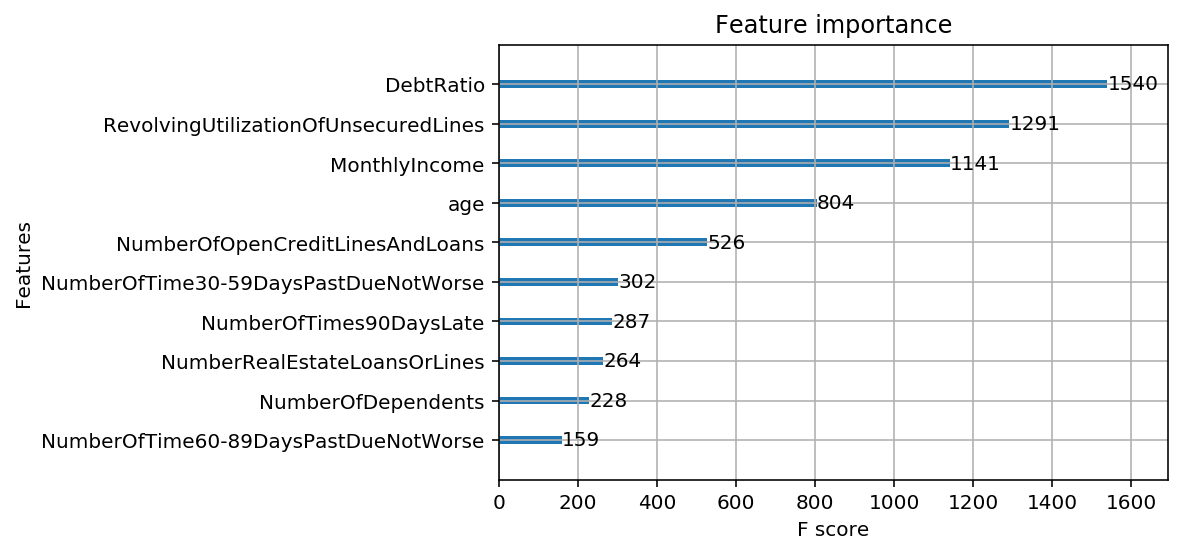

In [8]:
xgb.plot_importance(xgb_classi)

The most important variable in predicting delinquency is DebtRatio, because it has the highest F-score of 1540.
The most important pair of variables would be DebtRatio and RevolvingUtilizationOfUnsecuredLines, they have the two highest F-scores.

### 1.3

In [13]:
#Seperate Under 40 years old and 40 or older

under40 = X[X['age'] < 40]
over40 = X[X['age'] >= 40]

#Predict Probability for both age group
preds_under40 = xgb_classi.predict_proba(under40)[:,1]
print("Probability of delinquency with for people under age 40 is: %0.5f" %preds_under40.mean())
preds_over40 = xgb_classi.predict_proba(over40)[:,1]
print("Probability of delinquency with for people who are 40 or older is: %0.5f" %preds_over40.mean())

Probability of delinquency with for people under age 40 is: 0.10521
Probability of delinquency with for people who are 40 or older is: 0.05643


Base on the probability showing above, our model will predict the people who are age under 40 will have about 5% higher chance of delinquency in 2 yrs compare to those who are 40 or older. And the percentage shows that the model does not discriminate against people of age 40 or older since they have lower probability for being classified as delinquency.

### 1.4

In [21]:
#Seperate group of people based on number dependents

#First Checked unique values in column NumberOfDependents
print train_df.NumberOfDependents.unique()

#Group them based on their number of dependents
depend_0 = X[X['NumberOfDependents'] == 0]
depend_1 = X[X['NumberOfDependents'] == 1]
depend_2 = X[X['NumberOfDependents'] == 2]
depend_3 = X[X['NumberOfDependents'] == 3]
depend_4 = X[X['NumberOfDependents'] == 4]
depend_5 = X[X['NumberOfDependents'] == 5]
depend_6 = X[X['NumberOfDependents'] == 6]
depend_7 = X[X['NumberOfDependents'] == 7]
depend_8 = X[X['NumberOfDependents'] == 8]
depend_9 = X[X['NumberOfDependents'] == 9]
depend_10 = X[X['NumberOfDependents'] == 10]
depend_13 = X[X['NumberOfDependents'] == 13]
depend_20 = X[X['NumberOfDependents'] == 20]
hasDepend = X[X['NumberOfDependents'] != 0]
#Predict probability of Delinquency
preds_depend_0 = xgb_classi.predict_proba(depend_0)[:,1]
print("Probability of delinquency with for people with 0 Dependent is: %0.5f" %preds_depend_0.mean())
preds_depend_1 = xgb_classi.predict_proba(depend_1)[:,1]
print("Probability of delinquency with for people with 1 Dependent is: %0.5f" %preds_depend_1.mean())
preds_depend_2 = xgb_classi.predict_proba(depend_2)[:,1]
print("Probability of delinquency with for people with 2 Dependent is: %0.5f" %preds_depend_2.mean())
preds_depend_3 = xgb_classi.predict_proba(depend_3)[:,1]
print("Probability of delinquency with for people with 3 Dependent is: %0.5f" %preds_depend_3.mean())
preds_depend_4 = xgb_classi.predict_proba(depend_4)[:,1]
print("Probability of delinquency with for people with 4 Dependent is: %0.5f" %preds_depend_4.mean())
preds_depend_5 = xgb_classi.predict_proba(depend_5)[:,1]
print("Probability of delinquency with for people with 5 Dependent is: %0.5f" %preds_depend_5.mean())
preds_depend_6 = xgb_classi.predict_proba(depend_6)[:,1]
print("Probability of delinquency with for people with 6 Dependent is: %0.5f" %preds_depend_6.mean())
preds_depend_7 = xgb_classi.predict_proba(depend_7)[:,1]
print("Probability of delinquency with for people with 7 Dependent is: %0.5f" %preds_depend_7.mean())
preds_depend_8 = xgb_classi.predict_proba(depend_8)[:,1]
print("Probability of delinquency with for people with 8 Dependent is: %0.5f" %preds_depend_8.mean())
preds_depend_9 = xgb_classi.predict_proba(depend_9)[:,1]
print("Probability of delinquency with for people with 9 Dependent is: %0.5f" %preds_depend_9.mean())
preds_depend_10 = xgb_classi.predict_proba(depend_10)[:,1]
print("Probability of delinquency with for people with 10 Dependent is: %0.5f" %preds_depend_10.mean())
preds_depend_13 = xgb_classi.predict_proba(depend_13)[:,1]
print("Probability of delinquency with for people with 13 Dependent is: %0.5f" %preds_depend_13.mean())
preds_depend_20 = xgb_classi.predict_proba(depend_20)[:,1]
print("Probability of delinquency with for people with 20 Dependent is: %0.5f" %preds_depend_20.mean())
preds_hasDepend = xgb_classi.predict_proba(hasDepend)[:,1]
print("Probability of delinquency with for people with any number of Dependents is: %0.5f" %preds_hasDepend.mean())


[  2.   1.   0.  nan   3.   4.   5.   6.   8.   7.  20.  10.   9.  13.]
Probability of delinquency with for people with 0 Dependent is: 0.05863
Probability of delinquency with for people with 1 Dependent is: 0.07322
Probability of delinquency with for people with 2 Dependent is: 0.08180
Probability of delinquency with for people with 3 Dependent is: 0.08794
Probability of delinquency with for people with 4 Dependent is: 0.10283
Probability of delinquency with for people with 5 Dependent is: 0.09205
Probability of delinquency with for people with 6 Dependent is: 0.14287
Probability of delinquency with for people with 7 Dependent is: 0.10279
Probability of delinquency with for people with 8 Dependent is: 0.07035
Probability of delinquency with for people with 9 Dependent is: 0.01563
Probability of delinquency with for people with 10 Dependent is: 0.00863
Probability of delinquency with for people with 13 Dependent is: 0.24474
Probability of delinquency with for people with 20 Dependent i

From the above probabilities for each group with different number of dependents, we can see a trend of higher probibility of delinquency when number of dependents is higher. But some cases like 4,8,10,20 do not prove the theory of increasing trend. This is probably due to low number of Ids that have 4,8,10 or 20 dependents, so the probility is not accurate. Therefore I group all the people that have dependents together, getting probibility of 0.07814, which is around 2% higher than the people who do not have dependents. The data shows people with no dependents is less likely to be classified with delinquency with people who have dependents. Next we will calculate the p-value to express confidency.

In [85]:
t,prob= stats.ttest_ind(preds_depend_0,preds_hasDepend, equal_var=False)
print("p-value is: ")
print(prob)


p-value is: 
2.09589914066e-199


From the calculated p-value, we can see that the p-value is smaller than 0.05, which indicates strong evidence against the null hypothesis, so we reject the null hypothesis.

## Q2

### Q2.A

Let X be a uniform distribution between (−1,1). 

Let Y=X^2.

These two variables are uncorrelated but dependent. The covariance of X and Y is zero, and therefore both random variables are uncorrelated.

However, you can see the variable Y is clearly dependent on the values of X, so they are dependent.


## Q2.B

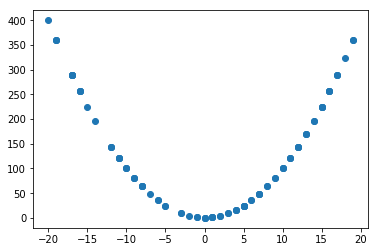

[[-0.64667709]]


In [68]:
##Part B

import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.linear_model

x = np.random.randint(-20,20,100)

z= np.random.randint(0,2,100)
    
y= (x**2)
x2= np.array(x)
z2=np.array(z)
y=np.array(y)

plt.scatter(x, y)
plt.show()

x=x.reshape(-1,1)
y=y.reshape(-1,1)

reg = LinearRegression()
reg.fit(x, y)
print(reg.coef_)


## Q3. a) Tensorflow/Keras tutorial

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


1.12.0


Import fashion MNIST dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 2s 1us/step


Explore the features

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
train_images.shape

(60000, 28, 28)

In [6]:
len(train_labels)

60000

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

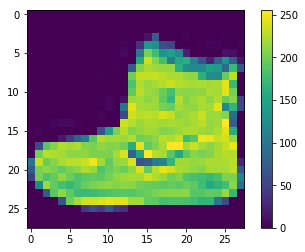

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)


rescale images before running through deep net

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0


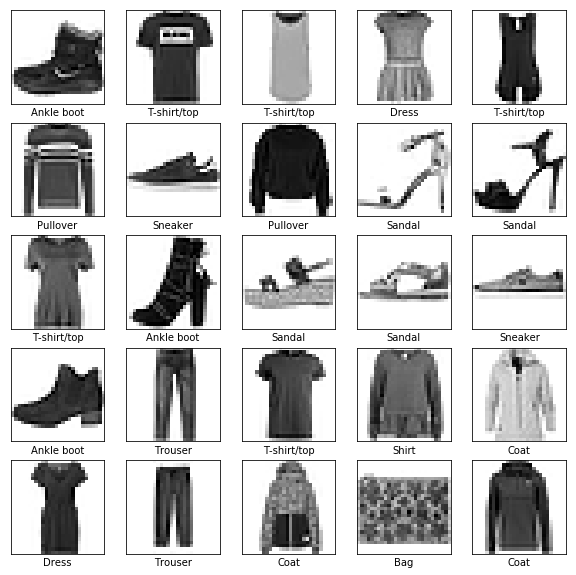

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])


make deep net with three layers:

1) flatten image
2) fully connected layer with relu activation
3) fully connected layer with softmax activation (probabilities)

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [16]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Train NN

In [17]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.5032 - acc: 0.8241
Epoch 2/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.3778 - acc: 0.8643
Epoch 3/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.3395 - acc: 0.8779
Epoch 4/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.3126 - acc: 0.8837
Epoch 5/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.2948 - acc: 0.8903


Test loss and accuracy (check for overfitting)

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)


10000/10000 [==============================] - 0s 30us/step
Test accuracy: 0.8752


running predictions

In [19]:
predictions = model.predict(test_images)


In [20]:
predictions[0]

array([7.8977209e-06, 2.1013300e-05, 9.7989357e-07, 1.2041208e-05,
       1.6139153e-05, 7.4518453e-03, 9.0912608e-06, 5.5391472e-02,
       1.1348465e-04, 9.3697608e-01], dtype=float32)

In [21]:
np.argmax(predictions[0])

9

In [22]:
test_labels[0]


9

Look at full set of 10 channels

In [24]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


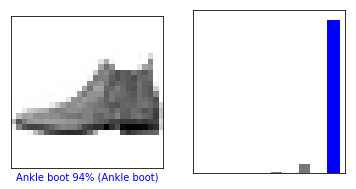

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


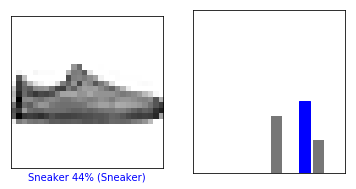

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)


plot several images with their predictions

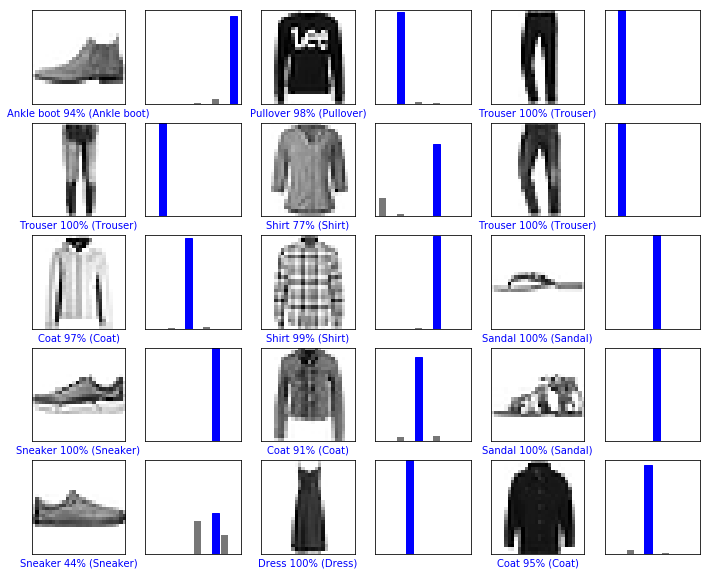

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Use trained model to make prediction on single image

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)


(28, 28)


In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


make prediction

In [30]:
predictions_single = model.predict(img)

print(predictions_single)


[[7.8977364e-06 2.1013320e-05 9.7989459e-07 1.2041196e-05 1.6139122e-05
  7.4518523e-03 9.0912445e-06 5.5391464e-02 1.1348465e-04 9.3697608e-01]]


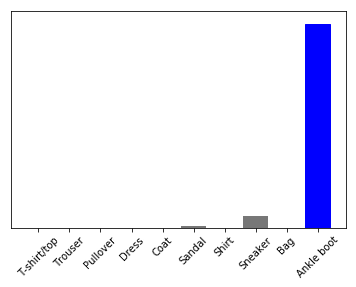

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)


In [32]:
np.argmax(predictions_single[0])

9

In [33]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


## Q3 b) Image Transformation and prediction

#### Image Augmentation

In [91]:
# select 5 images and transform them
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest')

In [92]:
def transformer(img, train_datagen):
    tmp = img
    tmp = (np.expand_dims(tmp,3))
    tmp = (np.expand_dims(tmp,3))
    train_datagen.fit(tmp)
    return (train_datagen.random_transform(np.expand_dims(img,0), seed=None)).reshape(28,28)

In [94]:
transformed = []

for i in range(5):
    transformed.append(transformer(test_images[i], train_datagen))

/home/daniel/Documents/Fall_2018/DSL/DataScienceLab/.env/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


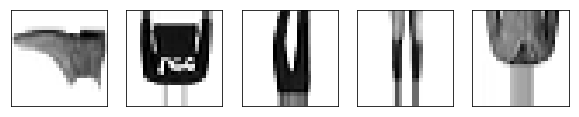

In [95]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(transformed[i], cmap=plt.cm.binary)

#### prediction on augmented images

In [99]:
test_images.shape

(10000, 28, 28)

In [103]:
transformed = np.array(transformed)
transformed.shape

(5, 28, 28)

In [104]:
aug_preds = model.predict(transformed)

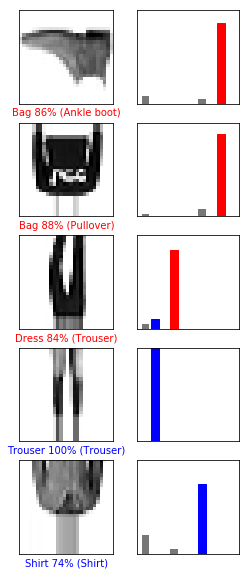

In [109]:
# Plot the 5 images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, aug_preds, test_labels, transformed)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, aug_preds, test_labels)

In [118]:
t_labels = [test_labels[i] for i in range(5)]
t_labels = np.array(t_labels)
t_labels.shape

(5,)

#### Observations

In [119]:
test_loss, test_acc = model.evaluate(transformed, t_labels)

print('Test accuracy:', test_acc)

5/5 [==============================] - 0s 498us/step
Test accuracy: 0.4000000059604645


For this test, I modified images from the test set because these simulate images that our model has never seen before. If we wanted to improve our classifier, we would perform image augmentation (random transforms) on the training set, so that it will improve its performance on test images.


## Q3. c) ImageNet

These are the images I have in my directory that I will run through the Inception classifier.

In [137]:
%%bash

cd ~/models/tutorials/image/imagenet
pwd
ls

/home/daniel/models/tutorials/image/imagenet
BUILD
classify_image.py
deadpool.jpeg
mouwser.jpeg
much_wow.jpeg


In [2]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

### Deadpool Classification

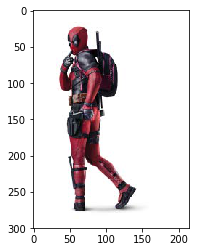

In [155]:
deadpool = Image.open('/home/daniel/models/tutorials/image/imagenet/deadpool.jpg', 'r')
imshow(np.asarray(deadpool))

In [156]:
%%bash

cd ~/models/tutorials/image/imagenet
python classify_image.py --image_file='deadpool.jpg'

cuirass (score = 0.18074)
breastplate, aegis, egis (score = 0.14944)
parachute, chute (score = 0.09794)
knee pad (score = 0.07775)
ski (score = 0.03096)


Instructions for updating:
Use tf.gfile.GFile.
2018-11-25 22:26:28.422003: W tensorflow/core/framework/op_def_util.cc:355] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2018-11-25 22:26:28.562353: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


Looks like this classifier has no idea that this is deadpool.

### Cat Classification

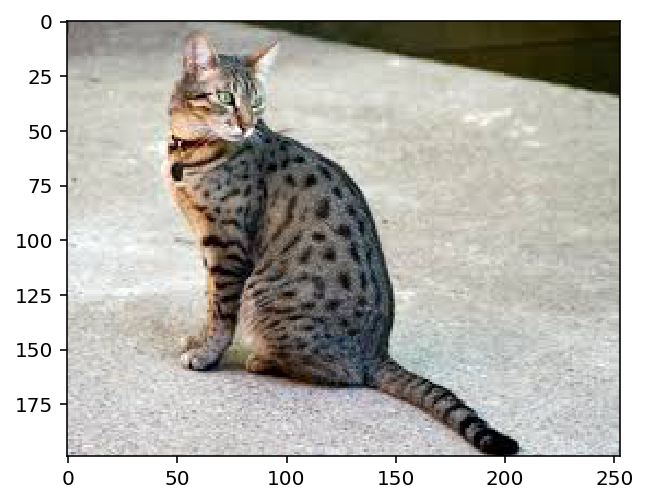

In [11]:
mouwsers = Image.open('/home/daniel/mouwser.jpeg', 'r')
imshow(np.asarray(mouwsers))

In [158]:
%%bash

cd ~/models/tutorials/image/imagenet
python classify_image.py --image_file='mouwser.jpg'

Egyptian cat (score = 0.06883)
washbasin, handbasin, washbowl, lavabo, wash-hand basin (score = 0.05592)
Angora, Angora rabbit (score = 0.03440)
soap dispenser (score = 0.02485)
bath towel (score = 0.02154)


Instructions for updating:
Use tf.gfile.GFile.
2018-11-25 22:27:39.316990: W tensorflow/core/framework/op_def_util.cc:355] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2018-11-25 22:27:39.447066: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


Highest score that the classifier gave is "Egyptian cat." Personally, I do not know if this cat is Egyptian, but it definitiely is a cat.

### Dog Classification

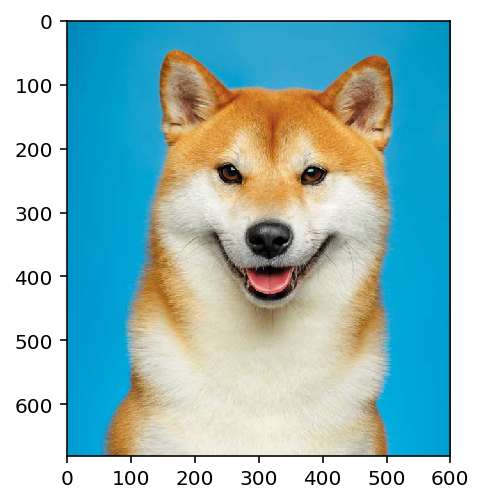

In [10]:
much_wow = Image.open('/home/daniel/much_wow.jpg','r')
imshow(np.asarray(much_wow))

In [159]:
%%bash

cd ~/models/tutorials/image/imagenet
python classify_image.py --image_file='much_wow.jpg'

Pembroke, Pembroke Welsh corgi (score = 0.10619)
screen, CRT screen (score = 0.09168)
television, television system (score = 0.04612)
Norwegian elkhound, elkhound (score = 0.03515)
dingo, warrigal, warragal, Canis dingo (score = 0.02655)


Instructions for updating:
Use tf.gfile.GFile.
2018-11-25 22:29:57.109948: W tensorflow/core/framework/op_def_util.cc:355] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2018-11-25 22:29:57.240810: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


Looks like the classifier's top guess is that this is a corgi. Indeed, the image is that of a dog. However, the classifier is almost as sure that the image is a dog, as it is sure that it is a TV.

## Q4 -- Project Proposal

#### Prompt: Form the final project teams and make your project proposal. What datasets are you planning to use/collect? What are you planning to do with them?

The team for our final project will consist of the following four members:
* Beathan Andersen (bta383)
* Jerry Yang (jhy395)
* Zhaofeng Liang (zl4685)
* Daniel Diamont (dd28977)

Project: Homebrew and/or Commercial Beer Recipe Cluster Analysis
Dataset: https://www.kaggle.com/jtrofe/beer-recipes

Our objective is to perform analysis on metadata about homebrew and commercial beers to determine key factors that influence consumer ratings of said beers. We hope to scrape data off of beer review websites to augment the Kaggle [Brewer's Friends Beer Recipes](https://www.kaggle.com/jtrofe/beer-recipes) dataset in order to obtain labeled data (e.g. style of beer, recipe, and consumer rating). We hope to collect enough data to cluster recipes and customers to gain insights as to the key factors that make beers more successful than others.
